## Dependencies

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-euq_5cb2
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-euq_5cb2
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp39-cp39-linux_x86_64.whl size=397885 sha256=86208a70e6e5b68e4469b9eabc87eab134c69b1f76e0a9c6d682d8cfa262371d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nwy5kcib/wheels/13/c1/d6/a321055f7089f1a6af654fbf794536b196999f082a9cb68a37
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.8.2



Cloning into 'vision'...
remote: Enumerating objects: 316973, done.
remote: Total 316973 (delta 0), reused 0 (delta 0), pack-reused 316973
Receiving objects: 100% (316973/316973), 646.27 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (291342/291342), done.


In [ ]:
%%shell


cp vision/references/detection/utils.py ./
cp vision/references/detection/transforms.py ./
cp vision/references/detection/coco_eval.py ./
cp vision/references/detection/engine.py ./
cp vision/references/detection/coco_utils.py ./

In [ ]:
!pwd

/content


## Data

In [ ]:
!wget "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
!unzip PennFudanPed.zip


--2023-03-10 15:50:36--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  11.1MB/s    in 5.7s    

2023-03-10 15:50:42 (8.94 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotati

In [ ]:
!wget "https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg" -O beatles.jpg

--2023-03-10 15:50:43--  https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114980 (112K) [image/jpeg]
Saving to: ‘beatles.jpg’

beatles.jpg         100%[===================>] 112.29K  --.-KB/s    in 0.004s  

2023-03-10 15:50:43 (24.4 MB/s) - ‘beatles.jpg’ saved [114980/114980]



## Import

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
# from torch.optim import lr_scheduler
from google.colab.patches import cv2_imshow
import transforms as TF
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torch.optim.lr_scheduler import StepLR
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
from engine import train_one_epoch, evaluate
import utils
import gc

In [ ]:
torch.cuda.empty_cache()

## Data Class

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

Example

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FE69DCC2EE0>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [ ]:
img, target = dataset[0]

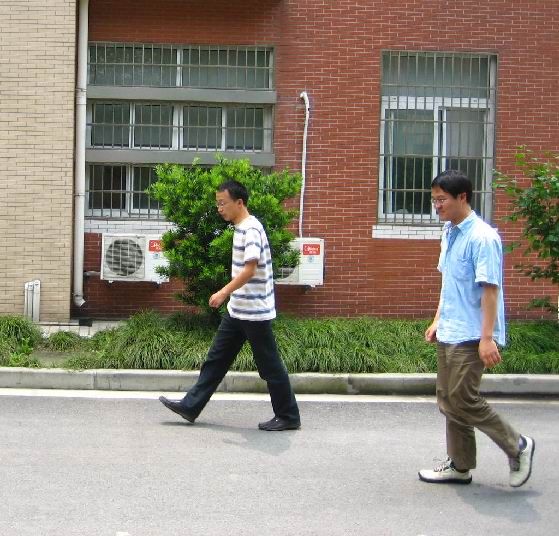

In [ ]:
img.show()

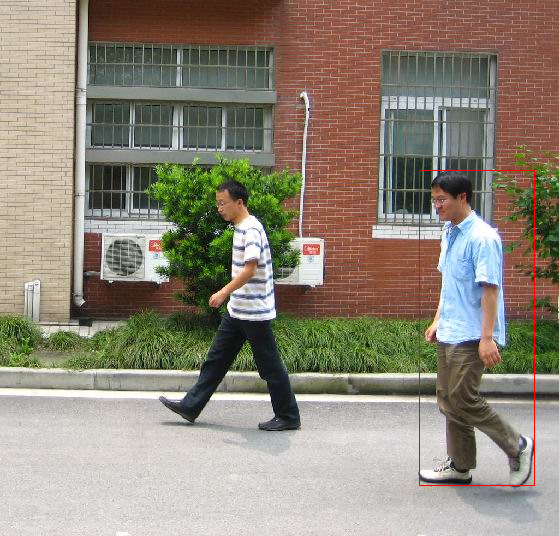

In [ ]:
draw = ImageDraw.Draw(img)
draw.rectangle(target['boxes'].numpy()[1], outline='red')
img.show()

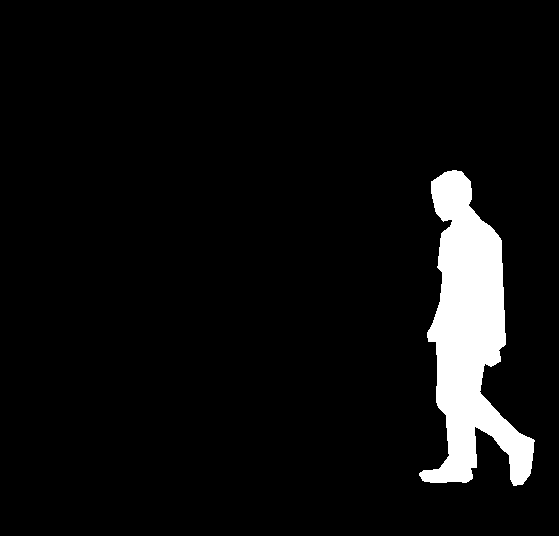

In [ ]:
Image.fromarray(target['masks'][1].mul(255).byte().cpu().numpy())

## Model-1

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
def get_model_1():
  num_classes=2
  # load an instance segmentation model pre-trained on COCO
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # now get the number of input features for the mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      num_classes)
  return model

In [ ]:
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def get_model_2():
  # load a pre-trained model for classification and return
  # only the features
  backbone = torchvision.models.mobilenet_v2(pretrained=True).features
  # FasterRCNN needs to know the number of
  # output channels in a backbone. For mobilenet_v2, it's 1280
  # so we need to add it here
  backbone.out_channels = 1280

  # let's make the RPN generate 5 x 3 anchors per spatial
  # location, with 5 different sizes and 3 different aspect
  # ratios. We have a Tuple[Tuple[int]] because each feature
  # map could potentially have different sizes and
  # aspect ratios 
  anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))

  # let's define what are the feature maps that we will
  # use to perform the region of interest cropping, as well as
  # the size of the crop after rescaling.
  # if your backbone returns a Tensor, featmap_names is expected to
  # be [0]. More generally, the backbone should return an
  # OrderedDict[Tensor], and in featmap_names you can choose which
  # feature maps to use.
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                  output_size=7,
                                                  sampling_ratio=2)

  # put the pieces together inside a FasterRCNN model
  model = MaskRCNN(backbone,
                    num_classes=2,
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)
  return model

In [ ]:
def get_transform(train):
    transforms = [
        TF.PILToTensor(), # converts the image, a PIL image, into a PyTorch Tensor
        TF.ConvertImageDtype(torch.float)
    ]
    
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(TF.RandomHorizontalFlip(0.5))
    return TF.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test forward method

In [ ]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_1()
# model_1.to(device)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images[:1])
# images = images.to(device)
targets = [{k: v for k, v in t.items()} for t in targets[:1]]
output = model(images,targets)   # Returns losses and detections
# For inference
x = [torch.rand(3, 500, 400), torch.rand(3, 500, 400)]
model.eval()
predictions = model(x)           # Returns predictions



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even fre

In [ ]:
torch.cuda.empty_cache()
gc.collect()

18

In [ ]:
model = get_model_2()
# model_2.to(device)
output = model(images,targets)
model.eval()
predictions = model(x)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
torch.cuda.empty_cache()
gc.collect()

73

## Train 

In [ ]:
num_epochs = 10

In [ ]:
def train_and_save(model, name):
  # construct an optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.005,
                              momentum=0.9, weight_decay=0.0005)

  # and a learning rate scheduler which decreases the learning rate by
  # 10x every 3 epochs
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
  torch.save(model.state_dict(), name+".pt")
  return model

### Model-1

In [ ]:
model_1 = get_model_1()
model_1.to(device)
model_1 = train_and_save(model_1, "option1")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [0]  [ 0/60]  eta: 0:09:11  lr: 0.000090  loss: 3.3232 (3.3232)  loss_classifier: 0.7210 (0.7210)  loss_box_reg: 0.2671 (0.2671)  loss_mask: 2.3216 (2.3216)  loss_objectness: 0.0110 (0.0110)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 9.1966  data: 0.4891  max mem: 2303
Epoch: [0]  [10/60]  eta: 0:01:05  lr: 0.000936  loss: 1.4068 (1.8605)  loss_classifier: 0.4050 (0.4277)  loss_box_reg: 0.2509 (0.2329)  loss_mask: 0.8596 (1.1799)  loss_objectness: 0.0110 (0.0156)  loss_rpn_box_reg: 0.0025 (0.0044)  time: 1.3132  data: 0.0524  max mem: 3037
Epoch: [0]  [20/60]  eta: 0:00:37  lr: 0.001783  loss: 0.8759 (1.3568)  loss_classifier: 0.2173 (0.3198)  loss_box_reg: 0.2514 (0.2648)  loss_mask: 0.3360 (0.7520)  loss_objectness: 0.0134 (0.0150)  loss_rpn_box_reg: 0.0040 (0.0052)  time: 0.5274  data: 0.0084  max mem: 3037
Epoch: [0]  [30/60]  eta: 0:00:24  lr: 0.002629  loss: 0.6417 (1.0838)  loss_classifier: 0.1103 (0.2408)  loss_box_reg: 0.2415 (0.2518)  loss_mask: 0.2174 (0.5740)  loss_ob

### Test on beetles image

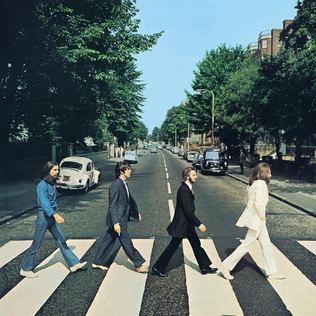

In [ ]:
img = read_image('beatles.jpg')
img = img/img.max()
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
model_1.eval()
with torch.no_grad():
  prediction_1 = model_1([img.to(device)])

In [ ]:
prediction_1[0]['masks'].shape

torch.Size([6, 1, 316, 316])

In [ ]:
mask_1 = torch.sum(prediction_1[0]['masks'][:,0], axis=0).mul(255).cpu().numpy()
# mask_1 = mask_1/mask_1.max()


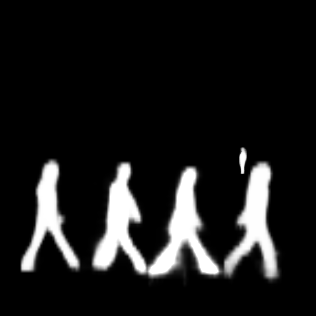

In [ ]:
cv2_imshow(mask_1.clip(0,255))

In [ ]:
torch.cuda.empty_cache()
gc.collect()

2908

### Model-2

In [ ]:
model_2 = get_model_2()
model_2.to(device)
model_2 = train_and_save(model_2, "option2")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower t

Epoch: [0]  [ 0/60]  eta: 0:01:28  lr: 0.000090  loss: 9.5842 (9.5842)  loss_classifier: 0.7387 (0.7387)  loss_box_reg: 0.0584 (0.0584)  loss_mask: 8.0471 (8.0471)  loss_objectness: 0.6940 (0.6940)  loss_rpn_box_reg: 0.0459 (0.0459)  time: 1.4771  data: 0.5257  max mem: 4619
Epoch: [0]  [10/60]  eta: 0:00:22  lr: 0.000936  loss: 5.3547 (6.0994)  loss_classifier: 0.4504 (0.4529)  loss_box_reg: 0.0598 (0.0575)  loss_mask: 3.9937 (4.8776)  loss_objectness: 0.6818 (0.6696)  loss_rpn_box_reg: 0.0410 (0.0418)  time: 0.4567  data: 0.0564  max mem: 5349
Epoch: [0]  [20/60]  eta: 0:00:16  lr: 0.001783  loss: 2.2690 (4.1713)  loss_classifier: 0.2558 (0.3662)  loss_box_reg: 0.0915 (0.0989)  loss_mask: 1.3872 (3.0948)  loss_objectness: 0.5693 (0.5714)  loss_rpn_box_reg: 0.0362 (0.0400)  time: 0.3605  data: 0.0095  max mem: 5349
Epoch: [0]  [30/60]  eta: 0:00:12  lr: 0.002629  loss: 1.6126 (3.3126)  loss_classifier: 0.2729 (0.3614)  loss_box_reg: 0.1383 (0.1286)  loss_mask: 0.7297 (2.3037)  loss_ob

### Test on beetles image

In [ ]:
model_2.eval()
with torch.no_grad():
  prediction_2 = model_2([img.to(device)])

In [ ]:
mask_2 = torch.sum(prediction_2[0]['masks'][:,0], axis=0).mul(255).cpu().numpy()
# mask_2 = mask_2/mask_2.max()

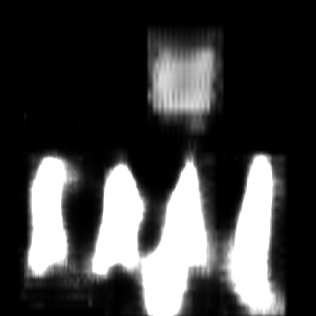

In [ ]:
cv2_imshow(mask_2.clip(0,255))

b. Option-1 performs better by judging the metric values. The same is confirmed by the inference on the image.

# References
[1] https://chat.openai.com/chathttps://chat.openai.com/chat

[2] https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html